Import Libraries

In [ ]:
pip install shap

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from collections import deque
import sys
from sklearn.metrics import accuracy_score
from numpy import loadtxt
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
import shap

Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/totalwithmaininfo.csv',sep=',')

In [ ]:
df.head()

,Participant,Y,MOE,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
4243,9,10,2.047761,0.316580,0.648279,0.539658,1.080068,-6.751045,4.427930,-5.933779
1066,3,0,3.320572,0.368293,1.222942,0.511161,-0.866254,0.844273,-0.949289,1.852600
5747,12,0,3.703925,0.253419,0.938645,0.384581,-1.812350,1.312562,-3.062524,2.182651
1146,3,0,3.431810,0.365446,1.254141,0.509185,-1.159172,1.690536,-1.167993,3.170307
9309,20,10,4.039789,0.272657,1.101476,0.428156,-0.744129,9.653955,-0.526897,1.662764


In [ ]:
participants = set(df.Participant)
df = df.drop(["Participant"], axis=1)

In [ ]:
#Form a binary problem
df.loc[df.Y == 0.0, "Y"] = int(0)
df.loc[df.Y == 10.0, "Y"] = int(1)


In [ ]:
train_percentage = 17/22
train_index = int(len(df)*train_percentage)
test_index = len(df)-train_index

In [ ]:
df_train = df[:train_index]
df_test = df[-test_index:]

In [ ]:
X_test = df_test.drop(["Y"],axis=1)
y_test = df_test["Y"]

In [ ]:
X_train = df_train.drop('Y',axis=1)
y_train = df_train['Y']

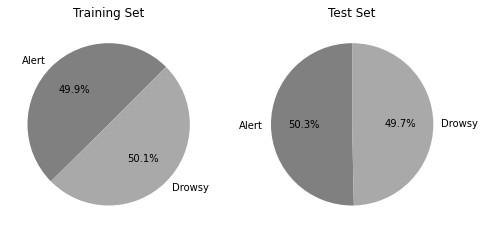

In [ ]:
# see label distribution
label = 'Alert', 'Drowsy'
plt.figure(figsize = (8,8))
plt.subplot(121)
plt.title("Training Set")
plt.pie(df_train.groupby('Y').size(), labels = label, autopct='%1.1f%%', startangle=45, colors={"grey", "darkgrey"})
plt.subplot(122)
plt.title("Test Set")
plt.pie(df_test.groupby('Y').size(), labels = label, autopct='%1.1f%%', startangle=90, colors={"grey", "darkgrey"})
plt.show()

In [ ]:
def average(y_pred):
  for i in range(len(y_pred)):
    if i % 240 == 0 or (i+1) % 240 == 0:
      pass
    else: 
      average = float(y_pred[i-1] +  y_pred[i] + y_pred[i+1])/3
      if average >= 0.5:
        y_pred[i] = 1
      else:
        y_pred[i] = 0
  return y_pred

1. Logistic Regression

In [ ]:
clf = LogisticRegression().fit(X_train, y_train)
y_pred_1 = clf.predict(X_test)
y_pred_1 = average(y_pred_1)
y_score_1 = clf.predict_proba(X_test)[:,1]
acc1 = accuracy_score(y_test, y_pred_1)
f1_score_1 = metrics.f1_score(y_test, y_pred_1,average='micro')
roc_1 = metrics.roc_auc_score(y_test, y_score_1)


print("Accuracy: {:3f} \nF1-Score: {:3f} \nROC: {:3f}".format(acc1,f1_score_1,roc_1))
print(confusion_matrix(y_test, y_pred_1))
print(f"Correct classified items {np.trace(confusion_matrix(y_test, y_pred_1))} based on {y_test.shape[0]} test records")

Accuracy: 0.557500 
F1-Score: 0.557500 
ROC: 0.623746
[[868 340]
 [722 470]]
Correct classified items 1338 based on 2400 test records


In [ ]:
#log odds represented by logistic regression coefficients
log_odds = clf.coef_[0]
pd.DataFrame(log_odds, 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
MOE_N,0.192290
EAR_N,0.117469
Circularity_N,0.114226
MAR_N,0.000059
MOE,-0.105560
MAR,-0.534358
EAR,-0.598918
Circularity,-1.882178


In [ ]:
#regular odds represented by logistic regression coefficients
odds = np.exp(clf.coef_[0])
pd.DataFrame(odds, 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
MOE_N,1.212023
EAR_N,1.124647
Circularity_N,1.121005
MAR_N,1.000059
MOE,0.899820
MAR,0.586046
EAR,0.549406
Circularity,0.152258


2. Naive Bayes

In [ ]:
clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)
pred_NB = clf_NB.predict(X_test)
pred_NB = average(pred_NB)
y_score_2 = clf_NB.predict_proba(X_test)[:,1]
acc2 = accuracy_score(y_test, pred_NB)
f1_score_2 = metrics.f1_score(y_test, pred_NB, average='micro')
roc_2 = metrics.roc_auc_score(y_test, y_score_2)

print([acc2,f1_score_2,roc_2])
print(confusion_matrix(y_test, pred_NB))

[0.58625, 0.58625, 0.7113791862971688]
[[1089  119]
 [ 874  318]]


3. KNN

In [ ]:
leaf_size = list(range(1,30))
n_neighbors = list(range(1,30))
p=[1,2]

In [ ]:
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p) 

In [ ]:
knn_ = KNeighborsClassifier()

In [ ]:
clf = GridSearchCV(knn_, hyperparameters, cv=10)

In [ ]:
best_model = clf.fit(X_train,y_train)

In [ ]:
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 3


In [ ]:
pred_KN = clf.predict(X_test)
pred_KN = average(pred_KN)
classification_report(y_test, pred_KN)

'              precision    recall  f1-score   support\n\n           0       0.73      0.74      0.74      1208\n           1       0.73      0.72      0.73      1192\n\n    accuracy                           0.73      2400\n   macro avg       0.73      0.73      0.73      2400\nweighted avg       0.73      0.73      0.73      2400\n'

In [ ]:
y_score_3 = clf.predict_proba(X_test)[:,1]
acc3 = accuracy_score(y_test, pred_KN)
f1_score_3 = metrics.f1_score(y_test, pred_KN)
roc_3 = metrics.roc_auc_score(y_test, y_score_3)
print("Accuracy: {:3f} \nF1-Score: {:3f} \nROC: {:3f}".format(acc3, f1_score_3, roc_3))
print(confusion_matrix(y_test, pred_KN))
print(f"Correct classified items {np.trace(confusion_matrix(y_test, pred_KN))} based on {y_test.shape[0]} test records")

Accuracy: 0.732500 
F1-Score: 0.728656 
ROC: 0.903484
[[896 312]
 [330 862]]
Correct classified items 1758 based on 2400 test records


4. MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

F1_score_4_list = []
acc4_list = []
roc_4_list = []
mlp = []

hidden_units = [10,20,30,40,50,60,70]
optimizer = ['sgd','adam','lbfgs']
activation = ['logistic','tanh','relu']
for j in activation:
    for i in optimizer:
        for k in hidden_units:
              clf_MLP = MLPClassifier(hidden_layer_sizes= k, activation =  j, solver= i)
              clf_MLP.fit(X_train, y_train)
              pred_MLP = clf_MLP.predict(X_test)
              pred_MLP = average(pred_MLP)
              y_score_4 = clf_MLP.predict_proba(X_test)[:,1]
              acc4_list.append(accuracy_score(y_test,pred_MLP))
              roc_4_list.append(metrics.roc_auc_score(y_test, y_score_4))
              F1_score_4_list.append(metrics.f1_score(y_test, pred_MLP))
              mlp.append([j,i,k])

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

In [ ]:
print("Best Accuracy: ", max(acc4_list))
min_index = acc4_list.index(max(acc4_list))
print("Best Combination:", mlp[min_index])

Best Accuracy:  0.7220833333333333
Best Combination: ['logistic', 'lbfgs', 50]


In [ ]:
clf_MLP = MLPClassifier(hidden_layer_sizes= mlp[min_index][2], activation =  mlp[min_index][0], solver= mlp[min_index][1])
clf_MLP.fit(X_train, y_train)
pred_MLP = clf_MLP.predict(X_test)
pred_MLP = average(pred_MLP)
y_score_4 = clf_MLP.predict_proba(X_test)[:,1]
acc4 = accuracy_score(y_test,pred_MLP)
f1_score_4 = metrics.f1_score(y_test, pred_MLP)
roc_4 = metrics.roc_auc_score(y_test, y_score_4)
print([acc4,f1_score_4,roc_4])
print(confusion_matrix(y_test, pred_MLP))

[0.6991666666666667, 0.686359687228497, 0.888351982310325]
[[888 320]
 [402 790]]


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


5. Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
acc5=[]
max_depth = []
for i in [2,3,4,5,6,7,8,9,10]:
    clf_DT = DecisionTreeClassifier(random_state=0, max_depth = i)
    clf_DT.fit(X_train, y_train)
    pred_DT = clf_DT.predict(X_test)
    pred_DT = average(pred_DT)
    acc5.append(accuracy_score(pred_DT, y_test))
    max_depth.append(i)
acc_5 = max(acc5)
print (acc_5)

0.7125


In [ ]:
best_depth = max_depth[acc5.index(max(acc5))]

In [ ]:
best_depth

10

In [ ]:
clf_DT = DecisionTreeClassifier(random_state=0, max_depth = best_depth)
clf_DT.fit(X_train, y_train)
pred_DT = clf_DT.predict(X_test)
pred_DT = average(pred_DT)
y_score_5 = clf_DT.predict_proba(X_test)[:,1]
acc5 = accuracy_score(y_test, pred_DT)
f1_score_5 = metrics.f1_score(y_test, pred_DT)
roc_5 = metrics.roc_auc_score(y_test, y_score_5)
print([acc5,f1_score_5,roc_5])
print(confusion_matrix(y_test, pred_DT))

[0.7125, 0.7018150388936906, 0.8848532156984754]
[[898 310]
 [380 812]]


6. Random Forest

In [ ]:
acc6=[]
max_depth = []
for i in range(1,10):
    clf_RF = RandomForestClassifier(max_depth=i)
    clf_RF.fit(X_train, y_train) 
    pred_RF = clf_RF.predict(X_test)
    pred_RF = average(pred_RF)
    acc6.append(accuracy_score(pred_RF, y_test))
    max_depth.append(i)
print (max(acc6))

0.7233333333333334


In [ ]:
best_depth_6 = max_depth[acc6.index(max(acc6))]

In [ ]:
best_depth_6

9

In [ ]:
clf_RF = RandomForestClassifier(max_depth=best_depth_6)
clf_RF.fit(X_train, y_train) 
pred_RF = clf_RF.predict(X_test)
pred_RF = average(pred_RF)
y_score_6 = clf_RF.predict_proba(X_test)[:,1]
acc6 = accuracy_score(y_test, pred_RF)
f1_score_6 = metrics.f1_score(y_test, pred_RF)
roc_6 = metrics.roc_auc_score(y_test, y_score_6)
print([acc6,f1_score_6,roc_6])
print(confusion_matrix(y_test, pred_RF))

[0.7154166666666667, 0.6842348589921405, 0.9150899762211654]
[[977 231]
 [452 740]]


### Feature importance

In [ ]:
feature_importances = pd.DataFrame(clf_RF.feature_importances_,index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)

In [ ]:
feature_importances

,importance
MAR_N,0.218246
MOE_N,0.176508
MAR,0.144128
EAR_N,0.133787
EAR,0.098151
Circularity_N,0.098015
MOE,0.079427
Circularity,0.051738


7. CNN

In [ ]:
X_train_shaped = np.expand_dims(X_train, axis=2)

In [ ]:

X_train_shaped.shape

(8160, 8, 1)

In [ ]:
X_test_shaped = np.expand_dims(X_test, axis=2)

In [ ]:
X_test_shaped.shape

(2400, 8, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers import Dropout
## Create Model ##

model = Sequential()

model.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (8,1)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))


## Compile Model 
optimizer = Adam(lr=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Train Model and Check Validation Accuracy 
model.fit(X_train_shaped, y_train, validation_data = (X_test_shaped,y_test), epochs = 100)

The `lr` argument is deprecated, use `learning_rate` instead.


Epoch 1/100
255/255 [==============================] - 2s 4ms/step - loss: 0.6802 - accuracy: 0.4990 - val_loss: 0.6754 - val_accuracy: 0.4967
Epoch 2/100
255/255 [==============================] - 1s 3ms/step - loss: 0.6706 - accuracy: 0.5044 - val_loss: 0.6678 - val_accuracy: 0.4967
Epoch 3/100
255/255 [==============================] - 1s 3ms/step - loss: 0.6632 - accuracy: 0.5279 - val_loss: 0.6604 - val_accuracy: 0.5537
Epoch 4/100
255/255 [==============================] - 1s 3ms/step - loss: 0.6565 - accuracy: 0.6004 - val_loss: 0.6532 - val_accuracy: 0.6379
Epoch 5/100
255/255 [==============================] - 1s 3ms/step - loss: 0.6511 - accuracy: 0.6451 - val_loss: 0.6461 - val_accuracy: 0.6746
Epoch 6/100
255/255 [==============================] - 1s 3ms/step - loss: 0.6446 - accuracy: 0.6702 - val_loss: 0.6397 - val_accuracy: 0.6954
Epoch 7/100
255/255 [==============================] - 1s 4ms/step - loss: 0.6392 - accuracy: 0.6779 - val_loss: 0.6344 - val_accuracy: 0.7025

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6, 64)             256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                12320     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
__________________________________________________

In [ ]:
pred_cnn = (model.predict(X_test_shaped )> 0.5).astype("int32")
pred_cnn = average(pred_cnn)
y_score_7 = model.predict(X_test_shaped)
acc7 = accuracy_score(y_test, np.array(pred_cnn))
f1_score_7 = metrics.f1_score(y_test, pred_cnn)
roc_7 = metrics.roc_auc_score(y_test, y_score_7)
print([acc7,f1_score_7,roc_7])
print(confusion_matrix(y_test, pred_cnn))

[0.6470833333333333, 0.6263784737538598, 0.8028356815858483]
[[843 365]
 [482 710]]


8. XGB Boosting

In [ ]:
clf_XGB = XGBClassifier()
clf_XGB.fit(X_train, y_train)
pred_XGB = clf_XGB.predict(X_test)
pred_XGB = average(pred_XGB)
y_score_8 = clf_XGB.predict_proba(X_test)[:,1]
acc8 = accuracy_score(y_test,pred_XGB)
f1_score_8 = metrics.f1_score(y_test, pred_XGB)
roc_8 = metrics.roc_auc_score(y_test, y_score_8)

print([acc8,f1_score_8,roc_8])
print(confusion_matrix(y_test, pred_XGB))

[0.71125, 0.689655172413793, 0.8965967931908084]
[[937 271]
 [422 770]]


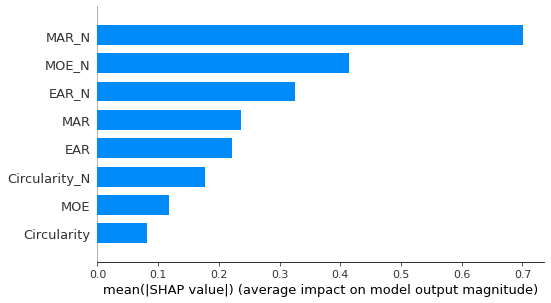

In [ ]:
explainer = shap.TreeExplainer(clf_XGB)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

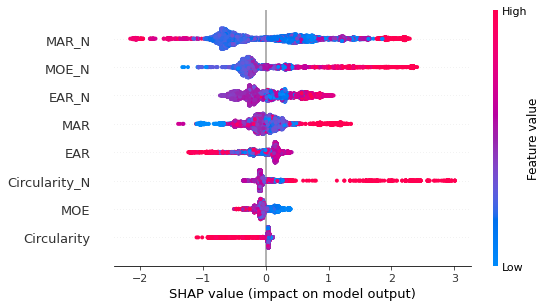

In [ ]:
explainer = shap.TreeExplainer(clf_XGB)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [ ]:
features = ["MAR", "EAR", "MOE", "Circularity", "MAR_N", "EAR_N", "MOE_N", "Circularity_N"]

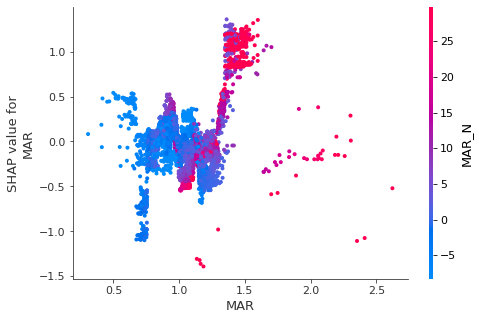

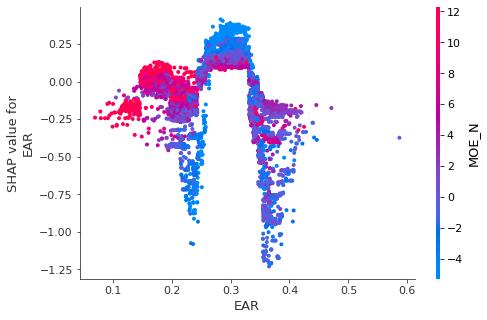

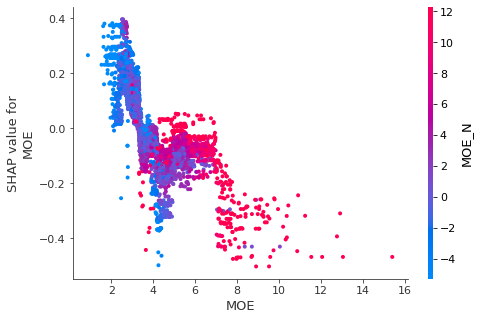

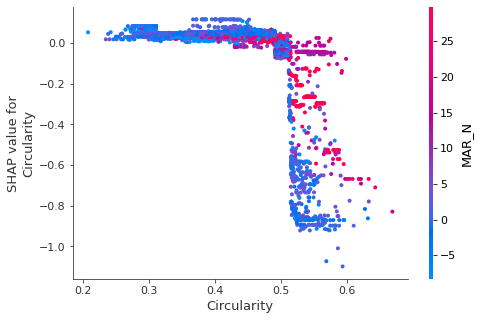

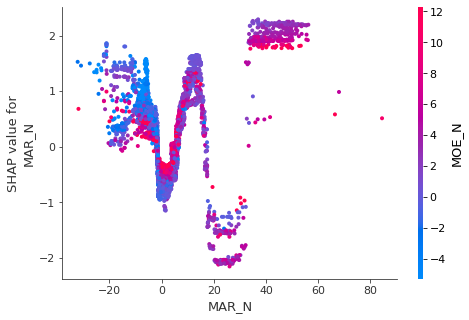

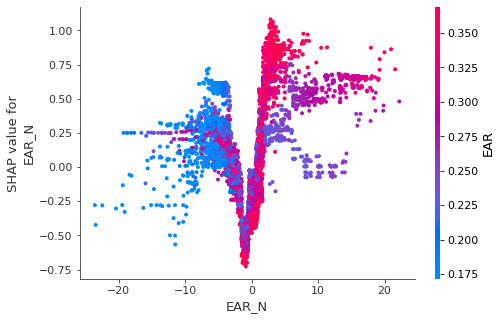

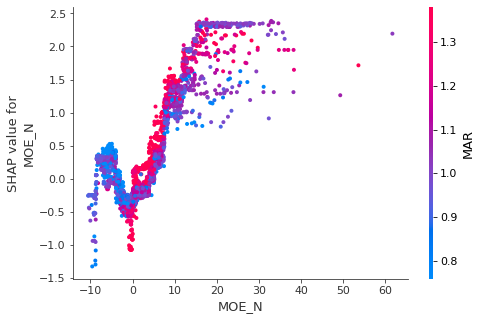

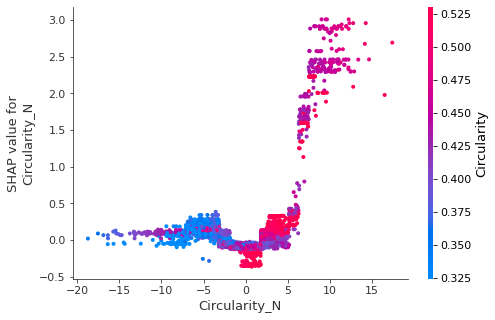

In [ ]:
for i in features:
  shap.dependence_plot(i, shap_values, X_train)

Comparing all models

,Accuracy
Model,
Logistic Regression,0.557500
Naive Bayes,0.586250
KNN,0.732500
MLP,0.699167
Decision Tree,0.712500
Random Forest,0.715417
CNN,0.647083
XGB Boosting,0.711250


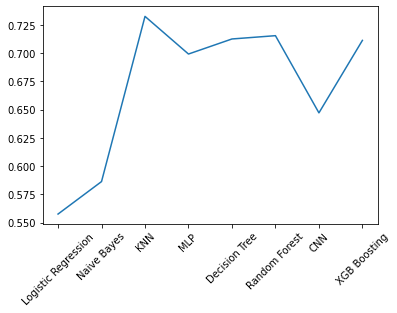

In [ ]:
acc_total = {'Model':['Logistic Regression','Naive Bayes', 'KNN', 'MLP','Decision Tree','Random Forest', 'CNN', 'XGB Boosting'],
              'Accuracy':[acc1,acc2, acc3, acc4, acc_5,acc6,acc7, acc8]}
acc_total = pd.DataFrame(acc_total)
acc_total = acc_total.set_index('Model')
acc_total
plt.plot(acc_total['Accuracy'])
plt.xticks(rotation=45)
acc_total

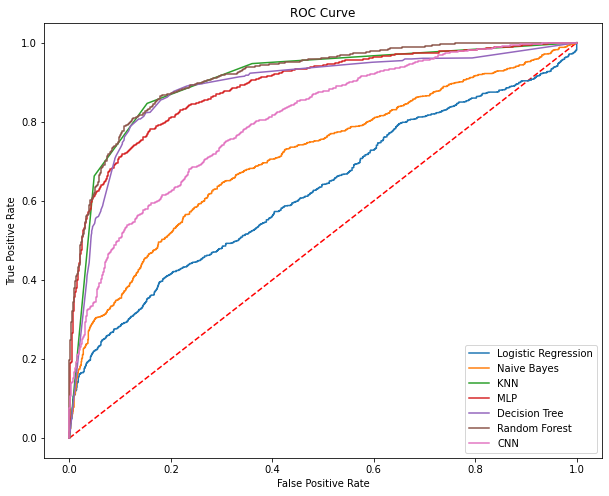

In [ ]:

plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1],'r--')
fpr_1, tpr_1, thresholds = roc_curve(y_test, y_score_1)
fpr_2, tpr_2, thresholds = roc_curve(y_test, y_score_2)
fpr_3, tpr_3, thresholds = roc_curve(y_test, y_score_3)
fpr_4, tpr_4, thresholds = roc_curve(y_test, y_score_4)
fpr_5, tpr_5, thresholds = roc_curve(y_test, y_score_5)
fpr_6, tpr_6, thresholds = roc_curve(y_test, y_score_6)
fpr_7, tpr_7, thresholds = roc_curve(y_test, y_score_7)
plt.plot(fpr_1, tpr_1, label= "Logistic Regression")
plt.plot(fpr_2, tpr_2, label= "Naive Bayes")
plt.plot(fpr_3, tpr_3, label= "KNN")
plt.plot(fpr_4, tpr_4, label= "MLP")
plt.plot(fpr_5, tpr_5, label= "Decision Tree")
plt.plot(fpr_6, tpr_6, label= "Random Forest")
plt.plot(fpr_7, tpr_7, label= "CNN")
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

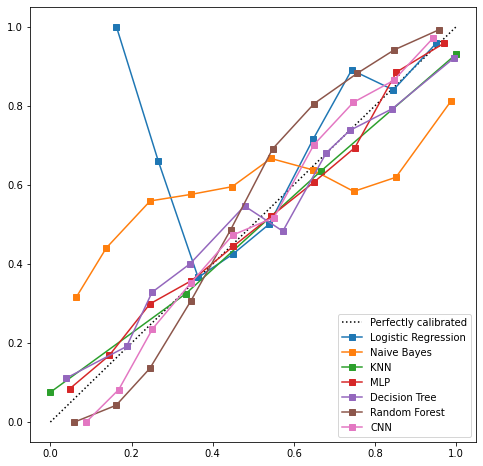

In [ ]:
from sklearn.calibration import calibration_curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value=calibration_curve(y_test,y_score_1,n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,"s-", label="%s" % 'Logistic Regression')
fraction_of_positives, mean_predicted_value=calibration_curve(y_test,y_score_2,n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,"s-", label="%s" % 'Naive Bayes')
fraction_of_positives, mean_predicted_value=calibration_curve(y_test,y_score_3,n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,"s-", label="%s" % 'KNN')
fraction_of_positives, mean_predicted_value=calibration_curve(y_test,y_score_4,n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,"s-", label="%s" % 'MLP')
fraction_of_positives, mean_predicted_value=calibration_curve(y_test,y_score_5,n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,"s-",label="%s" % 'Decision Tree')
fraction_of_positives, mean_predicted_value=calibration_curve(y_test,y_score_6,n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,"s-", label="%s" % 'Random Forest')
fraction_of_positives, mean_predicted_value=calibration_curve(y_test,y_score_7,n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,"s-",label="%s" % 'CNN')
plt.legend(loc="lower right")